# New Optical Design Version 2 1/5/2024
This is an ananlysis of the diulution measurements of the AS7341 device with a new cuvette holder with new optics. This is the second version of the design with a 1mm wide and 2mm deep hole for the photodiode of the AS7341 in relation to the cuvette with the rhodamine dye dilutions. 

# Methods
These methods for dilutions can be found at: https://github.com/COAST-Lab/Chlorophyll-Fluorometer-/blob/main/Data%20Analysis/AS7341%20Dilution%20Tests/AS7341_Dilutions_Methods.ipynb
CAD Design can be found at: https://github.com/jessiewynne/Chlorophyll-Fluorometer-/tree/main/Hardware

# Data
Data for these tests can be found at: https://github.com/jessiewynne/Chlorophyll-Fluorometer-/tree/main/Data%20Analysis/AS7341%20Dilution%20Tests/AS7341%20Dilutions%201.5.24

# Analysis 
This is the code for the analysis fo the dilution measurments taken on 1/5/2024 with the AS7341 device with the second version of the cuvette holder with new optics. 

### Import modules and file paths. Define catagories and create dictionaries 

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress, t
from sklearn.metrics import r2_score, mean_squared_error

# Replace with the actual file path
file_path = "/Users/jessiewynne/chla_fluorometer/AS7341 Dilutions 1.5.24/1_5_24_700ms_256x.csv"
# Read the CSV file without skipping any rows

df = pd.read_csv(file_path, encoding='utf-8')

# Filter out rows where the 'Test' column is 'test'
df = df[df['Test'].str.lower() != 'test'] 

# Convert 'F8 (Raw)' column to numeric values
df['F8 (Raw)'] = pd.to_numeric(df['F8 (Raw)'], errors='coerce')

# Get unique test categories (dilution values) in the order of appearance
categories = df['Test'].unique()

# Create a dictionary to store the 'F8 (Raw)' values for each category (dilution)
category_f8_raw_dict = {}

# Create dictionaries to store confidence intervals and ranges of uncertainty
confidence_intervals = {}
uncertainty_ranges = {}
lobs = {}  # To store LoB values
lods = {}  # To store LoD values

# Initialize mean_blank before the loop
mean_blank = 0.0

# Store unique x-values and their corresponding data points
x_values = []
y_values = []
std_devs = []

### For catagories complete calcultions 

In [15]:
for category in categories:
    # Exclude the first data point from each category
    category_df = df[df['Test'] == category][1:]
    category_f8_raw_dict[category] = category_df['F8 (Raw)']

    # Calculate the mean and standard deviation for 'F8 (Raw)' data in each category
    category_f8_raw_mean = category_df['F8 (Raw)'].mean()
    category_f8_raw_std = category_df['F8 (Raw)'].std()
    # print(category_f8_raw_mean)

    # Calculate the sample size for each category
    category_sample_size = len(category_df['F8 (Raw)'])

    # Calculate the standard error for each category's mean
    category_standard_error = category_f8_raw_std / np.sqrt(category_sample_size)

    # Define the confidence level (e.g., 95%)
    confidence_level = 0.95

    # Calculate the margin of error using the t-distribution
    margin_of_error = t.ppf((1 + confidence_level) / 2, category_sample_size - 1) * category_standard_error

    # Calculate the confidence interval for each category's mean
    confidence_interval = (category_f8_raw_mean - margin_of_error, category_f8_raw_mean + margin_of_error)

    # Calculate the range of uncertainty (95% CI width) for each category
    uncertainty_range = confidence_interval[1] - confidence_interval[0]

    # Check if the 'Test' value can be converted to a float, otherwise, skip it
    try:
        x_value = float(category)
        x_values.append(x_value)
        y_values.append(category_f8_raw_mean)
        std_devs.append(category_f8_raw_std)
    except ValueError:
        pass
# Calculate the mean and standard deviation for the entire dataset for 'F8 (Raw)' data
dataset_f8_raw_mean = df['F8 (Raw)'].mean()
dataset_f8_raw_std = df['F8 (Raw)'].std()

# Calculate the sample size for the entire dataset
dataset_sample_size = len(df['F8 (Raw)'])

# Calculate the standard error for the entire dataset's mean
dataset_standard_error = dataset_f8_raw_std / np.sqrt(dataset_sample_size)

# Calculate the margin of error using the t-distribution
confidence_level = 0.95
margin_of_error = t.ppf((1 + confidence_level) / 2, dataset_sample_size - 1) * dataset_standard_error

# Calculate the confidence interval for the entire dataset's mean
confidence_interval = (dataset_f8_raw_mean - margin_of_error, dataset_f8_raw_mean + margin_of_error)

# Calculate the range of uncertainty (95% CI width) for the entire dataset
uncertainty_range = confidence_interval[1] - confidence_interval[0]

# Calculate the minimum and maximum 'F8 (Raw)' values for each test category
min_f8_values = {}
max_f8_values = {}
for category, f8_raw_values in category_f8_raw_dict.items():
    min_f8_values[category] = f8_raw_values.min()
    max_f8_values[category] = f8_raw_values.max()

### Plot a figure with the mean F8 value for each test catagorey, error bars based on one standard deviation, a line of best fit, R-squared and RMSE

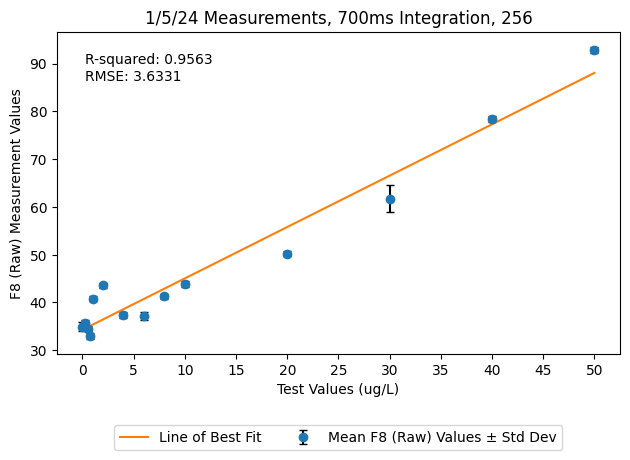

In [16]:
# Scatter plot for mean F8 values with error bars and legend
plt.errorbar(x_values, y_values, yerr=std_devs, fmt='o', capsize=3, ecolor='black', label='Mean F8 (Raw) Values ± Std Dev')

# Calculate the line of best fit parameters (slope and intercept)
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

# Create a function to calculate predicted values using the line of best fit equation
def predict_values(x, slope, intercept):
    return slope * x + intercept

# Plot the line of best fit
plt.plot(x_values, predict_values(np.array(x_values), slope, intercept), label='Line of Best Fit')

# Calculate R-squared and RMSE
y_predicted = predict_values(np.array(x_values), slope, intercept)
r_squared = r2_score(y_values, y_predicted)
rmse = np.sqrt(mean_squared_error(y_values, y_predicted))

# Set x-axis tick positions at intervals of 5
plt.xticks(np.arange(min(x_values), max(x_values)+1, 5))

plt.xlabel('Test Values (ug/L)')
plt.ylabel('F8 (Raw) Measurement Values')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)  # Move legend down and adjust layout
# plt.title("AS7341 Dilutions 256x Gain, 700ms Integration")
plt.title("1/5/24 Measurements, 700ms Integration, 256")

# Display R-squared and RMSE on the plot
plt.annotate(f'R-squared: {r_squared:.4f}\nRMSE: {rmse:.4f}', xy=(0.05, 0.85), xycoords='axes fraction')

plt.tight_layout()



### Create a second figure with the LoD value plotted, begin by calculating the LoB and LoD values

In [17]:
# Calculate mean and standard deviation for category '0.0' (blank) excluding the first measurement
category_0_0_df = df[df['Test'] == '0.0'][1:]
mean_blank = category_0_0_df['F8 (Raw)'].mean()
sd_blank = category_0_0_df['F8 (Raw)'].std()

# Print mean and standard deviation for '0.0' category
print(f"Mean for '0.0': {mean_blank:.4f}")
print(f"Standard Deviation for '0.0': {sd_blank:.4f}")

# Calculate LoB for category '0.0' excluding the first measurement
lob = mean_blank + 1.645 * sd_blank

# Calculate mean and standard deviation for category '0.25' (low concentration sample) excluding the first measurement
category_0_25_df = df[df['Test'] == '0.25'][1:]
sd_low_concentration_sample = category_0_25_df['F8 (Raw)'].std()

# Print mean and standard deviation for '0.25' category
print(f"Mean for '0.25': {category_0_25_df['F8 (Raw)'].mean():.4f}")
print(f"Standard Deviation for '0.25': {sd_low_concentration_sample:.4f}")

# Calculate LoD for category '0.25' excluding the first measurement
lod = lob + 1.645 * sd_low_concentration_sample

# Print LoB, LoD, and sd_low_concentration_sample values
print(f"LoB: {lob:.4f}")
print(f"LoD: {lod:.4f}")
print(f"SD Low Concentration Sample: {sd_low_concentration_sample:.4f}")

Mean for '0.0': 34.9333
Standard Deviation for '0.0': 0.8837
Mean for '0.25': 35.6667
Standard Deviation for '0.25': 0.6172
LoB: 36.3870
LoD: 37.4024
SD Low Concentration Sample: 0.6172


### Plot the LoD line and the line of best fit of the F8 values. Annotate on the grpah where the LoD line and line of best intersect. The intersection point is the limit of detection of the AS7341 device.

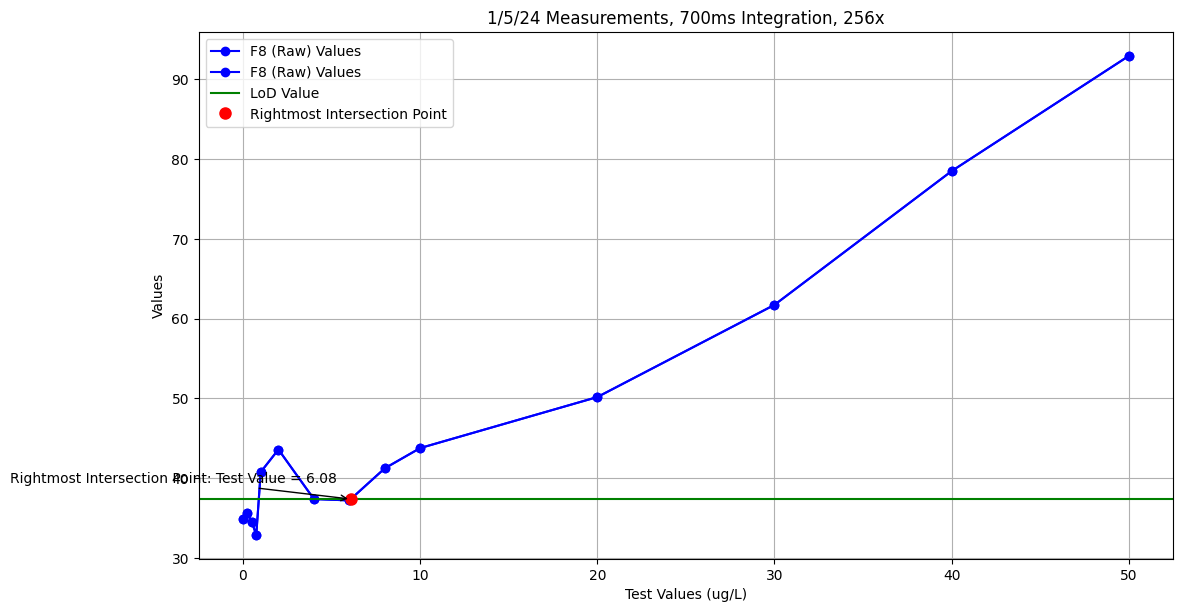

In [18]:
# Create a second figure for LoD values and F8 values vs. test categories
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed



# Plot F8 (Raw) values against test values (all categories)
plt.plot(x_values, y_values, marker='o', linestyle='-', color='blue', label='F8 (Raw) Values')

# Calculate the slope and intercept of the F8 values line
slope_f8_values = slope  # slope from the line of best fit
intercept_f8_values = intercept  # intercept from the line of best fit

# Assuming x_values contains your test values and lod is the singular LoD value

# List to store intersection points
intersection_points = []

# Initialize variables to track the rightmost LoD intersection point
max_intersection_x = float('-inf')
rightmost_intersection_point = None

# Calculate intersection points for the singular LoD value
for i in range(len(x_values) - 1):
    x1, x2 = x_values[i], x_values[i + 1]
    y1, y2 = y_values[i], y_values[i + 1]
    
    # Check if the LoD value is between the y-values of two adjacent x-values
    if min(y1, y2) <= lod <= max(y1, y2):
        slope = (y2 - y1) / (x2 - x1)
        intercept = y1 - slope * x1
        intersection_x = (lod - intercept) / slope

        # Update the rightmost intersection point
        if intersection_x > max_intersection_x:
            max_intersection_x = intersection_x
            rightmost_intersection_point = (intersection_x, lod)

# Plot F8 (Raw) values against test values
plt.plot(x_values, y_values, marker='o', linestyle='-', color='blue', label='F8 (Raw) Values')

# Plot LoD line and the rightmost intersection point
plt.axhline(y=lod, color='green', linestyle='-', label='LoD Value')
plt.plot([rightmost_intersection_point[0]], [rightmost_intersection_point[1]], marker='o', markersize=8, color='red', linestyle='None', label='Rightmost Intersection Point')

# Annotate the rightmost intersection point on the graph
plt.annotate(f'Rightmost Intersection Point: Test Value = {rightmost_intersection_point[0]:.2f}', 
             xy=rightmost_intersection_point, xycoords='data',
             xytext=(-10, 10), textcoords='offset points',
             arrowprops=dict(arrowstyle="->"),
             horizontalalignment='right', verticalalignment='bottom')

plt.xlabel('Test Values (ug/L)')
plt.ylabel('Values')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.title("1/5/24 Measurements, 700ms Integration, 256x")
plt.show()
